# Gold, Oil, NASDAQ, USD-index example

This notebook illustrates the toolkit's use on a real-world financial data set, using the weekly price of the gold, oil, the NASDAQ and an index of the USD.

For these four time series we fit three different multi-output Gaussian processes and show how they compare. For each model we optimize we repeat the experiment 5 times, to ensure robustness in the optimization and prediction.

Data sources:
- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

### Data loading
We will load the four financial time series and put them in a single data set for MOGPTK. Next we filter for a specific time range, in this case four years, and agregate the daily measurements into weeks. Additionally, we transform the Y axis in order to make training more effective.

For each of the channels we also remove certain ranges so that we can evaluate the effectiveness of data imputation in those regions. Each trial will additionally remove data points at random in order to verify the consistency of the results.

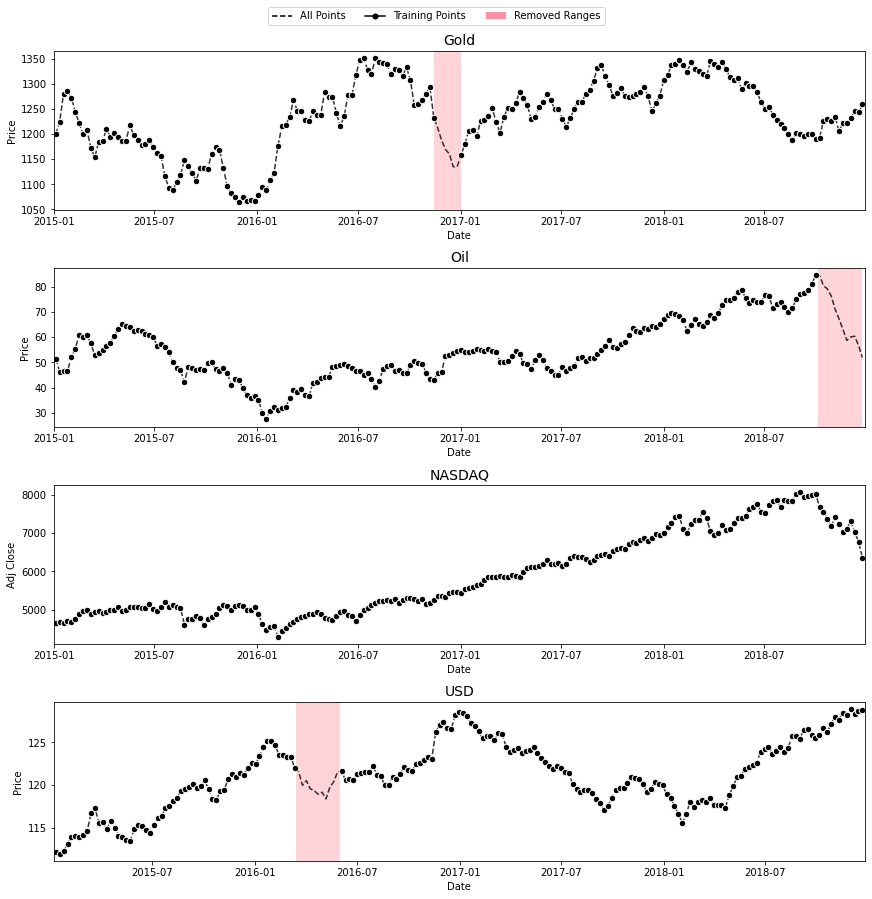

In [2]:
oil     = mogptk.LoadCSV('data/gonu/brent-daily.csv', 'Date', 'Price',
                         name='Oil')
gold    = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv', 'Date',
                         'Price', name='Gold', na_values='.')
nasdaq  = mogptk.LoadCSV('data/gonu/nasdaq.csv', 'Date', 'Adj Close',
                         name='NASDAQ')
usd     = mogptk.LoadCSV('data/gonu/TWEXB.csv', 'Date', 'Price',
                         name='USD')
dataset = mogptk.DataSet(gold, oil, nasdaq, usd)

# Remove points randomly to simulate sensor failure
np.random.seed(1)
for i, channel in enumerate(dataset):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7D')
    
    channel.transform(mogptk.TransformDetrend())
    channel.transform(mogptk.TransformNormalize())
    
    name = channel.get_name()
    if name == 'Gold':
        channel.remove_range('2016-11-15', '2017-01-01')
    if name == 'Oil':
        channel.remove_range('2018-10-05', None)
    if name == 'USD':
        channel.remove_range('2016-03-15', '2016-06-01')

dataset.plot();

We will be using the Adam optimizer, which is known to give good results using a relatively high learning rate, and we'll run five trials for each model in order to evaluate the consistency in our results.

In [3]:
n_trials = 5
Q = 3
init_method = 'BNSE'
method = 'Adam'
lr = 0.1
iters = 500

## Multi-output spectral mixture kernel

In [4]:
mosm_models = [None] * n_trials
mosm_mae = np.zeros((n_trials,4))
mosm_rmse = np.zeros((n_trials,4))
mosm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    mosm_dataset = dataset.copy()
    mosm_dataset['Gold'].remove_randomly(pct=0.6)
    mosm_dataset['Oil'].remove_randomly(pct=0.3)
    mosm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    mosm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=Q)
    mosm.init_parameters(init_method)
    try:
        mosm.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        mosm_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])
    mosm_models[n] = mosm


Trial 1 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 382
‣ Parameters: 73
‣ Initial loss: 396
‣ Initial error: 0.214

Optimization finished in 1 minute 29 seconds
‣ Function evaluations: 500
‣ Final loss: -209
‣ Final error: 0.0415

Trial 2 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 73
‣ Initial loss: 399
‣ Initial error: 0.202

Optimization finished in 1 minute 31 seconds
‣ Function evaluations: 500
‣ Final loss: -180
‣ Final error: 0.0308

Trial 3 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 381
‣ Parameters: 73
‣ Initial loss: 396
‣ Initial error: 0.213

Optimization finished in 1 minute 29 seconds
‣ Function evaluations: 500
‣ Final loss: -179
‣ Final error: 0.0354

Trial 4 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 73
‣ Init

In [5]:
pd.DataFrame(np.c_[mosm_mae.mean(1), mosm_rmse.mean(1), mosm_mape.mean(1),
             mosm_mae.std(1), mosm_rmse.std(1), mosm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,38.262657,50.769910,2.917239,52.823263,69.771420,2.719931
1,33.692203,44.176380,2.238317,44.271238,56.482674,1.471108
2,28.528953,39.477536,2.302173,34.622259,46.444495,1.680619
3,30.084566,42.959522,2.586228,38.791043,56.225945,2.368974
4,28.730429,40.964204,1.910456,36.317577,52.875013,1.231565


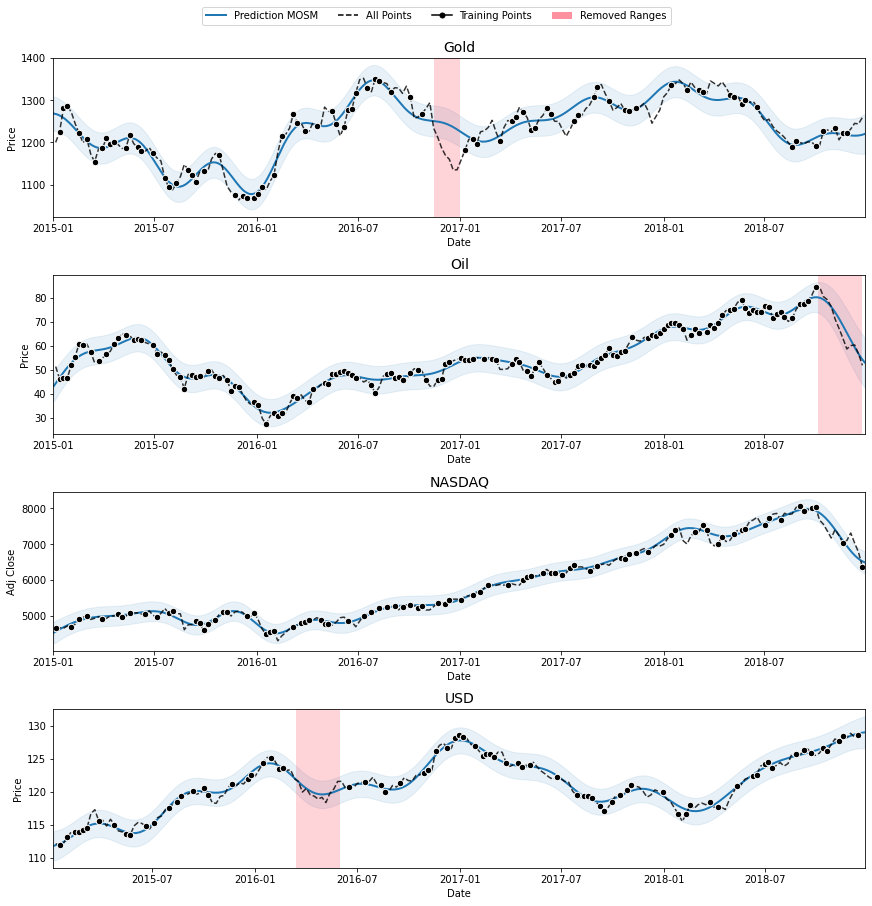

In [6]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.predict()
best_mosm.plot_prediction();

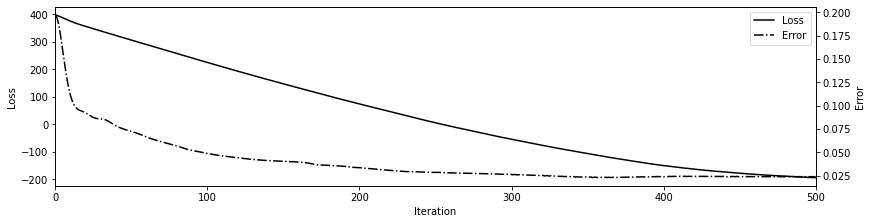

In [7]:
best_mosm.plot_losses()

### Auto-correlation and kernel evaluation at zero

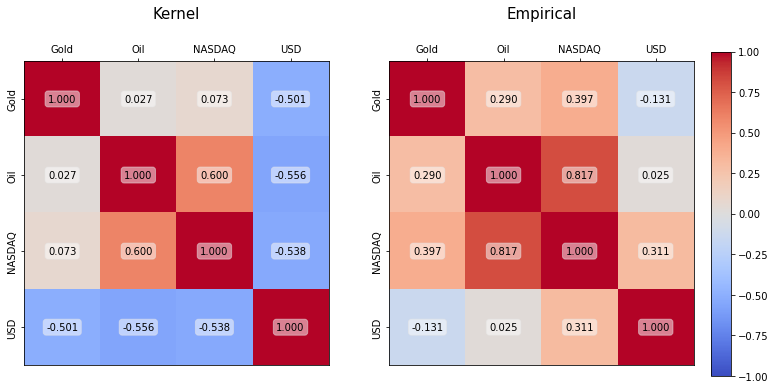

In [8]:
# Gram matrix
gram_matrix = best_mosm.get_gram_matrix(0, 0, n=1)

# autocorrelation
x_all, y_all = best_mosm.dataset.get_data()
y_all_array = np.empty((207, 0))
for y in y_all:
    y_all_array = np.c_[y_all_array, y[:207]]
auto_corr = np.corrcoef(y_all_array.T)

# normalize gram matrix
sqrt_diag = np.sqrt(np.diag(gram_matrix))
norm_gram_matrix = gram_matrix / np.outer(sqrt_diag, sqrt_diag)

f, axarray = plt.subplots(1, 2, figsize=(12, 8))
color_range = max(np.abs(norm_gram_matrix).max(), np.abs(auto_corr).max())

im = axarray[0].matshow(norm_gram_matrix, cmap='coolwarm', vmin=-color_range, vmax=color_range)
for (i, j), z in np.ndenumerate(norm_gram_matrix):
    axarray[0].text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[0].set_title('Kernel', y=1.12, fontsize=15)

im = axarray[1].matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)

for (i, j), z in np.ndenumerate(auto_corr):
    axarray[1].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[1].set_title('Empirical', y=1.12, fontsize=15)
axarray[0].set_yticks(np.arange(4));
axarray[0].set_yticklabels(dataset.get_names(), rotation=90, va='center');
axarray[0].set_xticks(np.arange(4));
axarray[0].set_xticklabels(dataset.get_names());
axarray[0].xaxis.set_ticks_position('top')

axarray[1].set_yticks(np.arange(4));
axarray[1].set_yticklabels(dataset.get_names(), rotation=90, va='center');
axarray[1].set_xticks(np.arange(4));
axarray[1].set_xticklabels(dataset.get_names());
axarray[1].xaxis.set_ticks_position('top')

cbar_ax = f.add_axes([.92, 0.22, 0.023, 0.563])
f.colorbar(im, cax=cbar_ax);

## Cross spectral mixture kernel

In [9]:
csm_models = [None] * n_trials
csm_mae = np.zeros((n_trials,4))
csm_rmse = np.zeros((n_trials,4))
csm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    csm_dataset['Gold'].remove_randomly(pct=0.6)
    csm_dataset['Oil'].remove_randomly(pct=0.3)
    csm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    csm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=Q)
    csm.init_parameters(init_method)
    try:
        csm.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        csm_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])
    csm_models[n] = csm


Trial 1 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 381
‣ Parameters: 43
‣ Initial loss: 408
‣ Initial error: 0.14

Optimization finished in 1 minute 14 seconds
‣ Function evaluations: 500
‣ Final loss: -162
‣ Final error: 0.0227

Trial 2 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 382
‣ Parameters: 43
‣ Initial loss: 410
‣ Initial error: 0.114

Optimization finished in 1 minute 14 seconds
‣ Function evaluations: 500
‣ Final loss: -157
‣ Final error: 0.027

Trial 3 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 376
‣ Parameters: 43
‣ Initial loss: 403
‣ Initial error: 0.196

Optimization finished in 1 minute 15 seconds
‣ Function evaluations: 500
‣ Final loss: -145
‣ Final error: 0.0301

Trial 4 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 383
‣ Parameters: 43
‣ Initial lo

In [10]:
pd.DataFrame(np.c_[csm_mae.mean(1), csm_rmse.mean(1), csm_mape.mean(1),
             csm_mae.std(1), csm_rmse.std(1), csm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,31.546872,41.341001,2.120167,42.136730,55.551737,1.457276
1,36.378212,48.113599,2.265632,51.314375,67.890222,1.619564
2,39.412109,49.325452,2.372660,56.216254,70.345255,1.514537
3,26.884996,34.028298,1.982558,33.476243,42.331350,1.229389
4,27.364458,35.856327,2.333886,35.594995,46.175396,1.954680


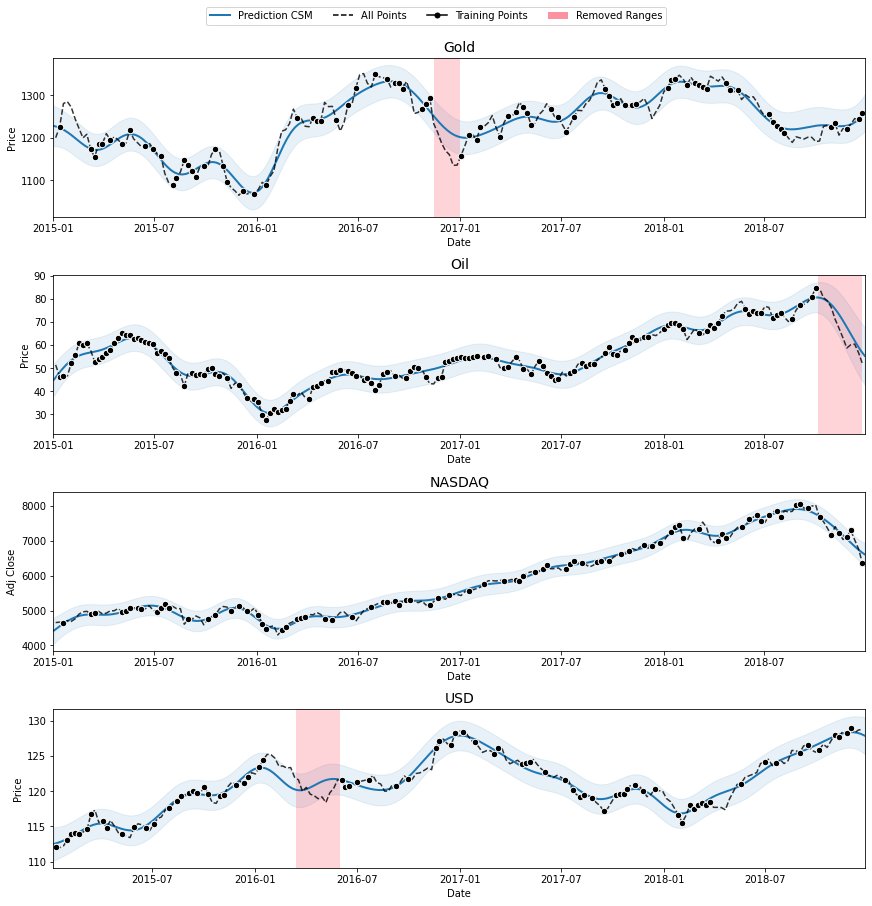

In [11]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.predict()
best_csm.plot_prediction();

## Linear model of coregionalization with spectral mixture kernels

In [12]:
smlmc_models = [None] * n_trials
smlmc_mae = np.zeros((n_trials,4))
smlmc_rmse = np.zeros((n_trials,4))
smlmc_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    smlmc_dataset['Gold'].remove_randomly(pct=0.6)
    smlmc_dataset['Oil'].remove_randomly(pct=0.3)
    smlmc_dataset['NASDAQ'].remove_randomly(pct=0.6)
    smlmc_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=Q)
    smlmc.init_parameters(init_method)
    try:
        smlmc.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        smlmc_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])
    smlmc_models[n] = smlmc


Trial 1 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 22
‣ Initial loss: 1.07e+03
‣ Initial error: 0.162

Optimization finished in 53 seconds
‣ Function evaluations: 500
‣ Final loss: -88.1
‣ Final error: 0.0485

Trial 2 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 378
‣ Parameters: 22
‣ Initial loss: 1.34e+03
‣ Initial error: 0.248

Optimization finished in 55 seconds
‣ Function evaluations: 500
‣ Final loss: -48
‣ Final error: 0.111

Trial 3 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 22
‣ Initial loss: 1.05e+03
‣ Initial error: 0.196

Optimization finished in 53 seconds
‣ Function evaluations: 500
‣ Final loss: -37.9
‣ Final error: 0.0325

Trial 4 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 384
‣ Parameters: 22
‣ Initial 

In [13]:
pd.DataFrame(np.c_[smlmc_mae.mean(1), smlmc_rmse.mean(1), smlmc_mape.mean(1),
             smlmc_mae.std(1), smlmc_rmse.std(1), smlmc_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,73.428881,89.518183,2.743858,114.492657,137.799459,1.696564
1,84.788072,115.237134,2.980702,122.269009,163.190073,1.595379
2,34.284625,45.444288,3.404409,46.166466,61.515383,3.605457
3,71.561724,96.534076,4.122218,91.233675,123.674457,1.885819
4,60.249389,74.337640,2.734665,92.652545,113.669116,1.891062


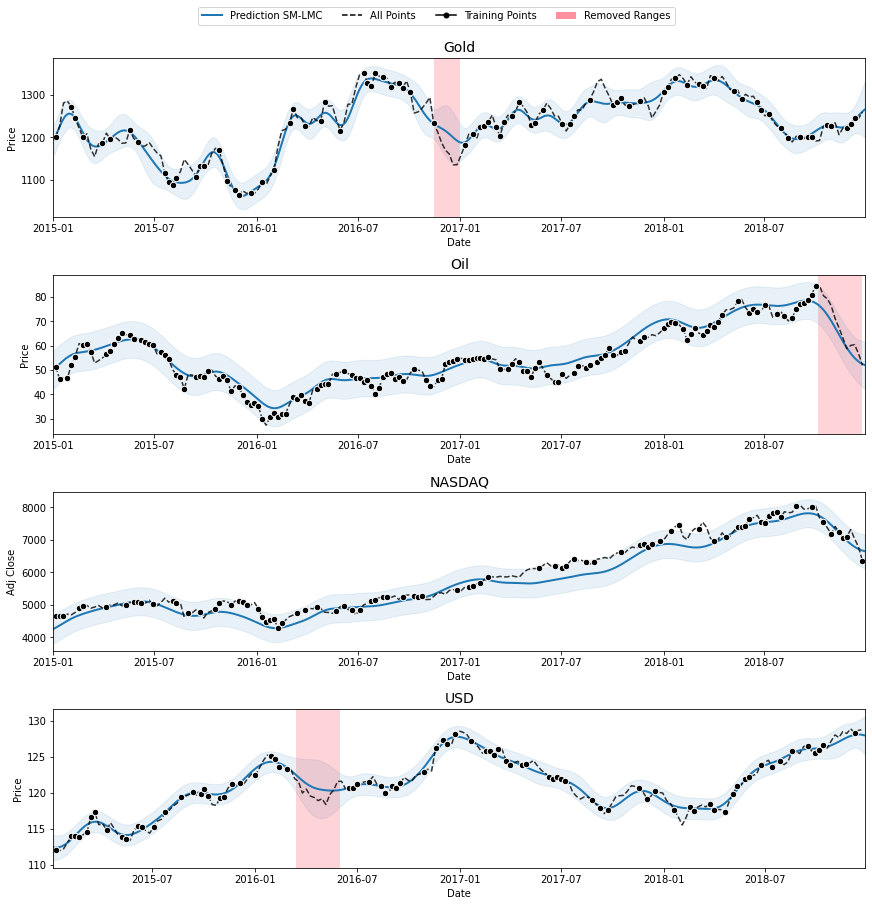

In [14]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.predict()
best_smlmc.plot_prediction();

In [15]:
best_smlmc.print_parameters()

Name,Range,Value
LMC.noise,"[1e-08, ∞)",[0.0089399 0.02837787 0.0442949 0.00698632]
LMC[0].SM.weight,fixed,[1.]
LMC[0].SM.mean,"[1e-08, 0.10300000000000023]",[1.70687573e-05]
LMC[0].SM.variance,"[1e-08, ∞)",[1.70247594e-05]
LMC[1].SM.weight,fixed,[1.]
LMC[1].SM.mean,"[1e-08, 0.10300000000000023]",[1.36192025e-05]
LMC[1].SM.variance,"[1e-08, ∞)",[2.50295806e-05]
LMC[2].SM.weight,fixed,[1.]
LMC[2].SM.mean,"[1e-08, 0.10300000000000023]",[0.00037697]
LMC[2].SM.variance,"[1e-08, ∞)",[7.02172145e-05]


# Independent spectral mixture kernels

In [16]:
sm_models = [None] * n_trials
sm_mae = np.zeros((n_trials,4))
sm_rmse = np.zeros((n_trials,4))
sm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    sm_dataset['Gold'].remove_randomly(pct=0.6)
    sm_dataset['Oil'].remove_randomly(pct=0.3)
    sm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    sm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=Q)
    sm.init_parameters(init_method)
    try:
        sm.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        sm_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])
    sm_models[n] = sm


Trial 1 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 381
‣ Parameters: 40
‣ Initial loss: 468
‣ Initial error: 0.0779

Optimization finished in 28 seconds
‣ Function evaluations: 500
‣ Final loss: -144
‣ Final error: 0.0305

Trial 2 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 383
‣ Parameters: 40
‣ Initial loss: 468
‣ Initial error: 0.086

Optimization finished in 29 seconds
‣ Function evaluations: 500
‣ Final loss: -141
‣ Final error: 0.0331

Trial 3 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 379
‣ Parameters: 40
‣ Initial loss: 464
‣ Initial error: 0.0848

Optimization finished in 28 seconds
‣ Function evaluations: 500
‣ Final loss: -137
‣ Final error: 0.0276

Trial 4 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 384
‣ Parameters: 40
‣ Initial loss: 468
‣ Initial error: 0.

In [17]:
pd.DataFrame(np.c_[sm_mae.mean(1), sm_rmse.mean(1), sm_mape.mean(1),
             sm_mae.std(1), sm_rmse.std(1), sm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,28.863142,38.460168,2.483474,37.898174,50.058951,2.170016
1,27.282717,38.158484,2.453602,34.936047,48.708637,2.202809
2,26.445034,35.994746,2.239364,34.071018,45.808231,1.914707
3,30.426103,43.135406,2.457729,39.783866,56.966897,2.031485
4,25.270910,34.410300,2.406662,31.056120,41.534430,2.240131


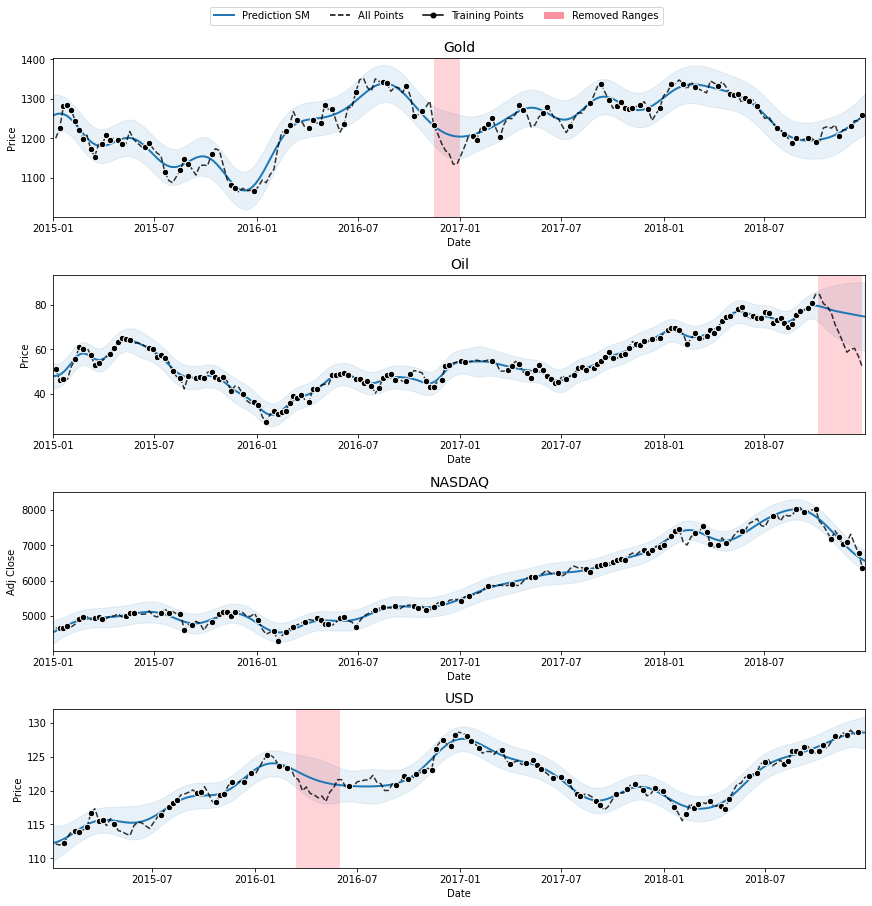

In [18]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.predict()
best_sm.plot_prediction();

## Results

In [19]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))

MAPE errors per model
MOSM:    2.39088 ± 0.339755
CSM:     2.21498 ± 0.144622
SM-LMC:  3.19717 ± 0.522479
SM:      2.40817 ± 0.0879644
